In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
import joblib

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    AVAILABLE_TS_FEATURES = {
        'year', 'month', 'day', 'dayofweek', 'day_name', 'dayofyear',
        'week', 'quarter', 'hour', 'minute', 'second',
        'is_weekend', 'hour_sin', 'hour_cos'
    }

    CATEGORICAL_TS_FEATURES = {'day_name', 'month', 'year', 'quarter'}

    def __init__(self,
                 timestamp_columns=None,
                 timestamp_features=None,
                 numeric_columns=None,
                 quantile_output_distribution='uniform',
                 quantile_n_quantiles=1000,
                 random_state=42):
        self.timestamp_columns = timestamp_columns or []
        self.timestamp_features = set(timestamp_features) if timestamp_features else self.AVAILABLE_TS_FEATURES
        self.numeric_columns = numeric_columns
        self.quantile_output_distribution = quantile_output_distribution
        self.quantile_n_quantiles = quantile_n_quantiles
        self.random_state = random_state

        self.quantile_transformers = {}

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # Определим числовые колонки, исключая timestamp
        if self.numeric_columns is None:
            self.numeric_columns_ = X.select_dtypes(include=[np.number]).columns.difference(self.timestamp_columns).tolist()
        else:
            self.numeric_columns_ = [col for col in self.numeric_columns if col not in self.timestamp_columns]

        # Обучим QuantileTransformer по числовым колонкам
        for col in self.numeric_columns_:
            qt = QuantileTransformer(
                output_distribution=self.quantile_output_distribution,
                n_quantiles=min(self.quantile_n_quantiles, X.shape[0]),
                random_state=self.random_state
            )
            qt.fit(X[[col]])
            self.quantile_transformers[col] = qt

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        result = pd.DataFrame(index=X.index)

        # Преобразуем числовые признаки
        for col in self.numeric_columns_:
            qt = self.quantile_transformers.get(col)
            if qt:
                result[f'{col}_qt'] = qt.transform(X[[col]]).flatten()

        # Временные признаки
        for col in self.timestamp_columns:
            ts = pd.to_datetime(X[col], unit='s')
            prefix = col
            temp = {}

            # Сначала извлечём все timestamp признаки
            if 'year' in self.timestamp_features:
                temp[f'{prefix}_year'] = ts.dt.year
            if 'month' in self.timestamp_features:
                temp[f'{prefix}_month'] = ts.dt.month
            if 'day' in self.timestamp_features:
                temp[f'{prefix}_day'] = ts.dt.day
            if 'dayofweek' in self.timestamp_features:
                temp[f'{prefix}_dayofweek'] = ts.dt.dayofweek
            if 'day_name' in self.timestamp_features:
                temp[f'{prefix}_day_name'] = ts.dt.day_name()
            if 'dayofyear' in self.timestamp_features:
                temp[f'{prefix}_dayofyear'] = ts.dt.dayofyear
            if 'week' in self.timestamp_features:
                temp[f'{prefix}_week'] = ts.dt.isocalendar().week
            if 'quarter' in self.timestamp_features:
                temp[f'{prefix}_quarter'] = ts.dt.quarter
            if 'hour' in self.timestamp_features:
                temp[f'{prefix}_hour'] = ts.dt.hour
            if 'minute' in self.timestamp_features:
                temp[f'{prefix}_minute'] = ts.dt.minute
            if 'second' in self.timestamp_features:
                temp[f'{prefix}_second'] = ts.dt.second
            if 'is_weekend' in self.timestamp_features:
                temp[f'{prefix}_is_weekend'] = (ts.dt.dayofweek >= 5).astype(int)
            if 'hour_sin' in self.timestamp_features:
                temp[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * ts.dt.hour / 24)
            if 'hour_cos' in self.timestamp_features:
                temp[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * ts.dt.hour / 24)

            temp_df = pd.DataFrame(temp)

            # One-hot-кодирование для категориальных timestamp признаков
            cat_features = [f'{prefix}_{f}' for f in self.CATEGORICAL_TS_FEATURES if f in self.timestamp_features]
            temp_df = pd.get_dummies(temp_df, columns=cat_features, drop_first=True, dtype=int)

            result = pd.concat([result, temp_df], axis=1)

        return result

    def save(self, path: str):
        joblib.dump(self, path)

    @staticmethod
    def load(path: str):
        return joblib.load(path)

In [2]:
raw_data = pd.read_parquet("..\\Data\\raw\\dataset.parquet")
raw_data.head()

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0


# Оценка качества на сырых данных

In [5]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

X_transformed = raw_data.drop(columns=['target', 'wallet_address'])
y = raw_data['target']

# Обучаем модель LightGBM
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_transformed, y)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

In [6]:
scores = cross_val_score(model, X_transformed, y, cv=5, scoring='roc_auc')
print(f"All raw features — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

All raw features — ROC AUC: 0.5062 ± 0.1228


# Оценка качества на дополнительных фичах

In [7]:
timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]
numeric_columns = raw_data.select_dtypes(include=["number"]).columns.to_list()
numeric_columns = [col for col in numeric_columns if col not in timestamp_columns]
numeric_columns.remove("target")
numeric_columns[:10]
feature_preproc = FeaturePreprocessor(timestamp_columns=timestamp_columns, numeric_columns=numeric_columns)

In [8]:
feature_preproc.fit(raw_data)

FeaturePreprocessor(numeric_columns=['borrow_block_number', 'wallet_age',
                                     'incoming_tx_count', 'outgoing_tx_count',
                                     'net_incoming_tx_count',
                                     'total_gas_paid_eth',
                                     'avg_gas_paid_per_tx_eth',
                                     'risky_tx_count',
                                     'risky_unique_contract_count',
                                     'risky_first_last_tx_timestamp_diff',
                                     'risky_sum_outgoing_amount_eth',
                                     'outgoing_tx_sum_eth',
                                     'incoming_tx_sum_eth',
                                     'outgoi...
                                     'borrow_amount_sum_eth',
                                     'borrow_amount_avg_eth', 'borrow_count', ...],
                    timestamp_columns=['borrow_timestamp', 'first_tx_timestamp',
                                       'last_tx_timestamp',
                                       'risky_first_tx_timestamp',
                                       'risky_last_tx_timestamp'],
                    timestamp_features={'day', 'day_name', 'dayofweek',
                                        'dayofyear', 'hour', 'hour_cos',
                                        'hour_sin', 'is_weekend', 'minute',
                                        'month', 'quarter', 'second', 'week',
                                        'year'})

In [9]:
preproc_data = feature_preproc.transform(raw_data)
preproc_data.head()

,borrow_block_number_qt,wallet_age_qt,incoming_tx_count_qt,outgoing_tx_count_qt,net_incoming_tx_count_qt,total_gas_paid_eth_qt,avg_gas_paid_per_tx_eth_qt,risky_tx_count_qt,risky_unique_contract_count_qt,risky_first_last_tx_timestamp_diff_qt,...,risky_last_tx_timestamp_month_12,risky_last_tx_timestamp_quarter_2,risky_last_tx_timestamp_quarter_3,risky_last_tx_timestamp_quarter_4,risky_last_tx_timestamp_day_name_Monday,risky_last_tx_timestamp_day_name_Saturday,risky_last_tx_timestamp_day_name_Sunday,risky_last_tx_timestamp_day_name_Thursday,risky_last_tx_timestamp_day_name_Tuesday,risky_last_tx_timestamp_day_name_Wednesday
0,0.0,0.481245,0.545546,0.612613,0.271271,0.257001,0.033436,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
1,0.0,0.481247,0.546547,0.613113,0.271271,0.257569,0.033545,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
2,0.0,0.481248,0.547548,0.613614,0.271271,0.258145,0.033678,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
3,0.0,0.022379,0.071071,0.241742,0.541542,0.309737,0.501857,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
4,0.0,0.000616,0.007007,0.016517,0.858859,0.004006,0.034700,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0


In [10]:
preproc_data = pd.concat([raw_data, preproc_data], axis=1)
preproc_data

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,risky_last_tx_timestamp_month_12,risky_last_tx_timestamp_quarter_2,risky_last_tx_timestamp_quarter_3,risky_last_tx_timestamp_quarter_4,risky_last_tx_timestamp_day_name_Monday,risky_last_tx_timestamp_day_name_Saturday,risky_last_tx_timestamp_day_name_Sunday,risky_last_tx_timestamp_day_name_Thursday,risky_last_tx_timestamp_day_name_Tuesday,risky_last_tx_timestamp_day_name_Wednesday
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,0,0,1,0,0,0,1,0,0,0
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,0,0,1,0,0,0,1,0,0,0
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,0,0,1,0,0,0,1,0,0,0
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,0,0,1,0,0,0,1,0,0,0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442956,18250961,1.696106e+09,0x3dc6d0168838c40e26d105115908ee833b24e56a,1.677567e+09,1.696106e+09,18539076.0,68,91,-23,0.352223,...,0,1,0,0,0,0,0,1,0,0
442957,18251701,1.696115e+09,0x3af16178664dd4b2500c9d02c53347e86b3e7873,1.624471e+09,1.695934e+09,71643811.0,154,168,-14,1.382943,...,0,0,0,0,0,0,0,1,0,0
442958,18251742,1.696116e+09,0xba01430a43496df98956e42aab08eb85ca107bb1,1.613776e+09,1.696116e+09,82339560.0,163,310,-147,1.218006,...,0,0,1,0,1,0,0,0,0,0
442959,18251864,1.696117e+09,0x1f2b17bff4a0313ec6342eef464742ad1c2de83c,1.671973e+09,1.695933e+09,24144360.0,117,221,-104,0.738964,...,0,0,1,0,0,0,0,1,0,0


In [30]:
X_transformed = preproc_data.drop(columns=['target', 'wallet_address'])
y = preproc_data['target']

# Обучаем модель LightGBM
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_transformed, y)

In [21]:
scores = cross_val_score(model, X_transformed, y, cv=5, scoring='roc_auc')
print(f"All features — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

All features — ROC AUC: 0.5308 ± 0.1164


Метрика подросла на 0.03. Не огонь, но лучше чем ничего

# Отбор признаков

## Удаление высоко коррелирующих признаков

In [31]:
corr_matrix = X_transformed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Найдём признаки с корреляцией > 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
len(to_drop)

36

In [32]:
to_drop[:20]

['borrow_timestamp',
 'last_tx_timestamp',
 'net_incoming_tx_count',
 'risky_last_tx_timestamp',
 'repay_amount_sum_eth',
 'market_macd_macdext',
 'market_macd',
 'market_macdsignal',
 'market_rocr',
 'borrow_block_number_qt',
 'incoming_tx_sum_eth_qt',
 'incoming_tx_avg_eth_qt',
 'risk_factor_qt',
 'total_available_borrows_avg_eth_qt',
 'liquidation_count_qt',
 'time_since_last_liquidated_qt',
 'liquidation_amount_sum_eth_qt',
 'market_atr_qt',
 'market_cci_qt',
 'market_cmo_qt']

In [33]:
X_transformed = X_transformed.drop(columns=to_drop)
X_transformed.shape

(442961, 285)

In [34]:
# Обучаем модель LightGBM
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_transformed, y)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

In [35]:
# Смотрим метрики
scores = cross_val_score(model, X_transformed, y, cv=5, scoring='roc_auc')
print(f"Features without high correlation — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Features without high correlation — ROC AUC: 0.5190 ± 0.1105


## Удаление признаков с низкой дисперсией

In [40]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
X_var = selector.fit_transform(X_transformed)

# # Получим имена оставшихся фичей
selected_features = X_transformed.columns[selector.get_support()]
print(len(selected_features))

177


Выбывшие кандидаты

In [45]:
# trash_columns = [col for col in X_transformed.columns if col not in selected_features]
# trash_columns

Сразу видно, что делать OneHot для месяцев не имеет смысла, а также квантование некоторых чисел тоже не приносить разнообразия в данных

In [42]:
X_transformed = X_transformed[selected_features]
X_transformed.shape

(442961, 177)

In [43]:
# Обучаем модель LightGBM
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_transformed, y)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

In [44]:
# Смотрим метрики
scores = cross_val_score(model, X_transformed, y, cv=5, scoring='roc_auc')
print(f"Features without low variance — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Features without low variance — ROC AUC: 0.5245 ± 0.1004


## Отбор количества признаков, которые дают максимальную эффективность

In [46]:
# import lightgbm as lgb
# import pandas as pd

# # Обучаем модель LightGBM
# model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
# model.fit(X_transformed, y)

In [47]:
# Получаем важность признаков
feature_importances = pd.Series(model.feature_importances_, index=X_transformed.columns)
feature_importances = feature_importances.sort_values(ascending=False)


feature_importances = pd.DataFrame(feature_importances).rename(columns={0:'Значимость'})
feature_importances['Значимость'] = round(100 * feature_importances['Значимость'] / feature_importances['Значимость'].sum(), 1)
feature_importances = feature_importances[feature_importances['Значимость'] != 0]
print(len(feature_importances))
feature_importances.head(20)

103


,Значимость
risk_factor,6.6
max_risk_factor,5.8
avg_risk_factor,4.8
total_available_borrows_avg_eth,4.8
time_since_first_deposit,4.2
borrow_block_number,4.0
risk_factor_above_threshold_daily_count,2.6
market_atr,2.4
borrow_count,1.9
wallet_age,1.8


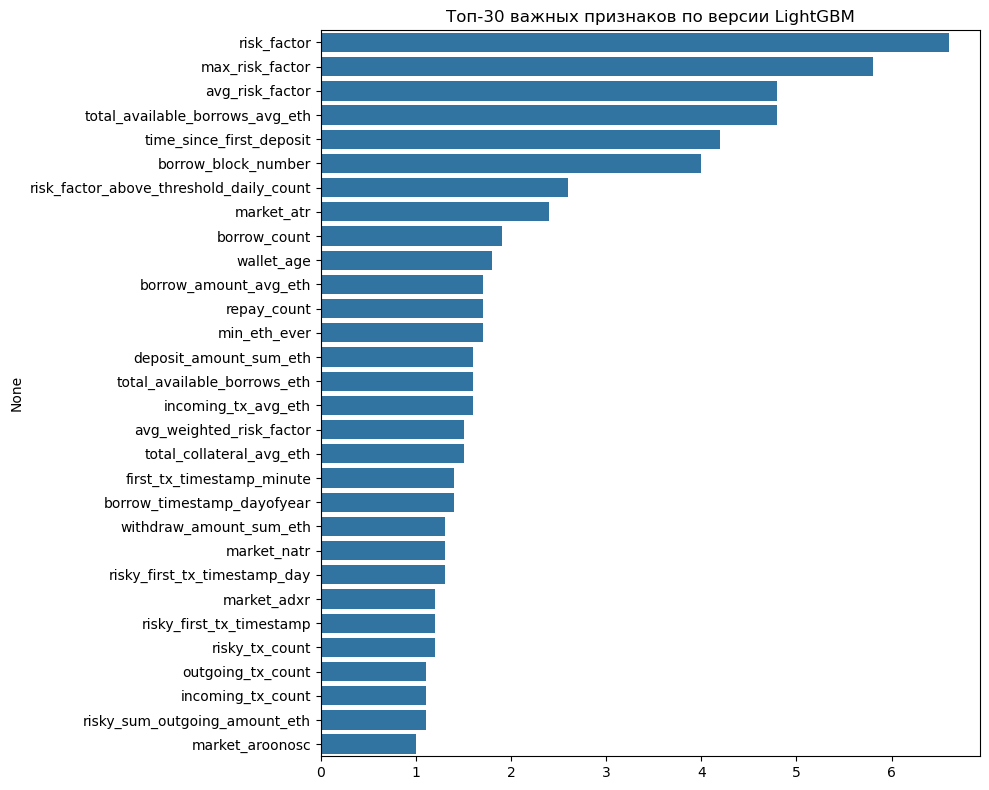

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.head(30)['Значимость'].values, y=feature_importances.head(30).index)
plt.title("Топ-30 важных признаков по версии LightGBM")
plt.tight_layout()
plt.show()

In [49]:
X_transformed.shape

(442961, 177)

In [66]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

results = []

# Проверим, как меняется качество при использовании разного числа признаков
for k in [25, 50, 75, 100, 105]:
    top_k_features = feature_importances.head(k).index.tolist()
    X_k = X_transformed[top_k_features]

    model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    scores = cross_val_score(model, X_k, y, cv=5, scoring='roc_auc')

    results.append({
        'n_features': k,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })
    print(f"Top {k} features — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Top 25 features — ROC AUC: 0.5043 ± 0.1191
Top 50 features — ROC AUC: 0.5204 ± 0.1292
Top 75 features — ROC AUC: 0.5204 ± 0.1158
Top 100 features — ROC AUC: 0.5232 ± 0.1064
Top 105 features — ROC AUC: 0.5221 ± 0.1296


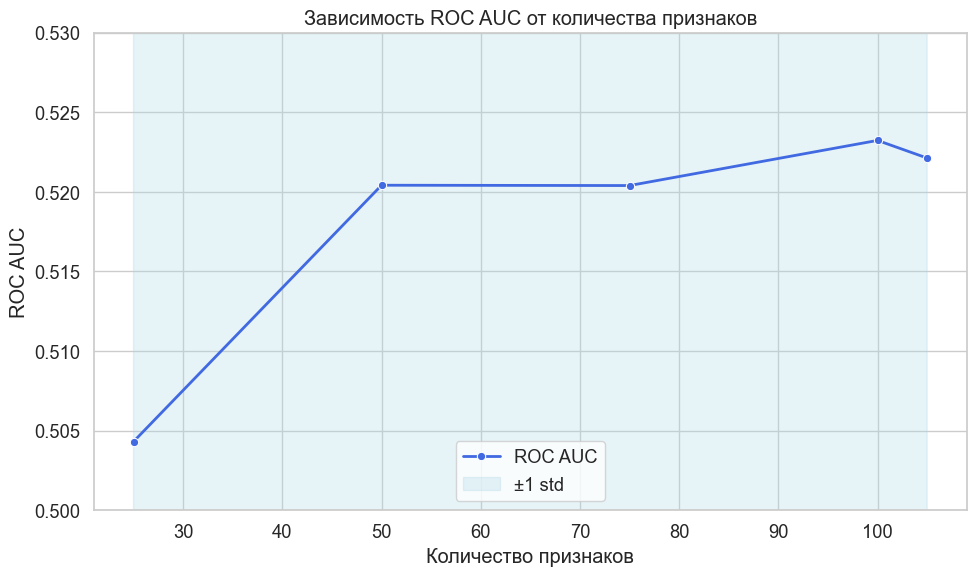

In [67]:
results_df = pd.DataFrame(results)

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=results_df,
    x='n_features',
    y='mean_score',
    marker='o',
    linewidth=2,
    color='royalblue',
    label='ROC AUC'
)

# Добавим "доверительный интервал" через std вручную
plt.fill_between(
    results_df['n_features'],
    results_df['mean_score'] - results_df['std_score'],
    results_df['mean_score'] + results_df['std_score'],
    color='lightblue',
    alpha=0.3,
    label='±1 std'
)

plt.title("Зависимость ROC AUC от количества признаков")
plt.xlabel("Количество признаков")
plt.ylabel("ROC AUC")
plt.ylim(0.50, 0.53)
plt.legend()
plt.tight_layout()
plt.show()

Искомое количество фичей находится около 100, посмотрим ближе

In [68]:
results = []
for k in [80, 85, 90, 95, 100, 105]:
    top_k_features = feature_importances.head(k).index.tolist()
    X_k = X_transformed[top_k_features]

    model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    scores = cross_val_score(model, X_k, y, cv=5, scoring='roc_auc')

    results.append({
        'n_features': k,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })
    print(f"Top {k} features — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Top 80 features — ROC AUC: 0.5244 ± 0.1231
Top 85 features — ROC AUC: 0.5359 ± 0.1146
Top 90 features — ROC AUC: 0.5294 ± 0.1221
Top 95 features — ROC AUC: 0.5234 ± 0.1168
Top 100 features — ROC AUC: 0.5232 ± 0.1064
Top 105 features — ROC AUC: 0.5221 ± 0.1296


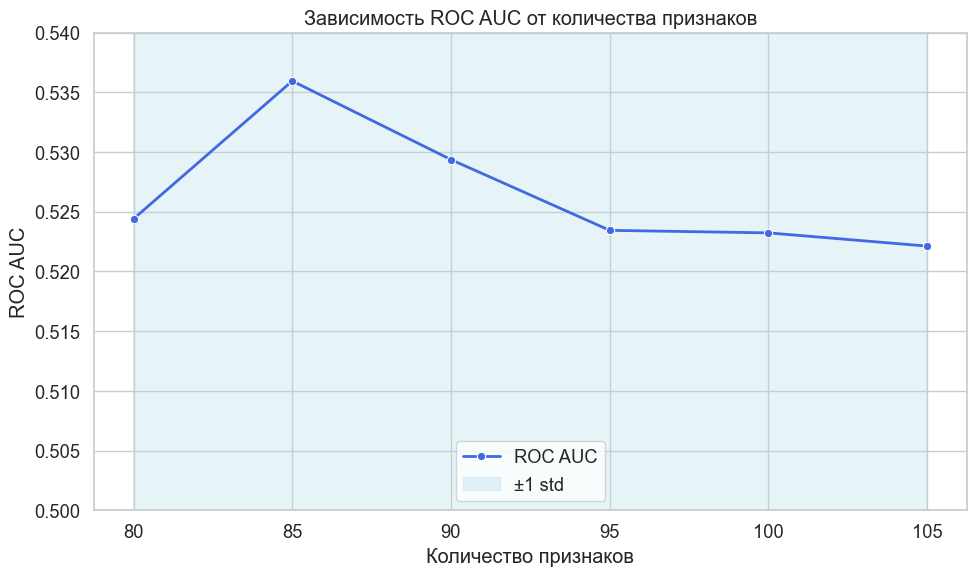

In [70]:
results_df = pd.DataFrame(results)

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=results_df,
    x='n_features',
    y='mean_score',
    marker='o',
    linewidth=2,
    color='royalblue',
    label='ROC AUC'
)

# Добавим "доверительный интервал" через std вручную
plt.fill_between(
    results_df['n_features'],
    results_df['mean_score'] - results_df['std_score'],
    results_df['mean_score'] + results_df['std_score'],
    color='lightblue',
    alpha=0.3,
    label='±1 std'
)

plt.title("Зависимость ROC AUC от количества признаков")
plt.xlabel("Количество признаков")
plt.ylabel("ROC AUC")
plt.ylim(0.50, 0.54)
plt.legend()
plt.tight_layout()
plt.show()

Ограничение до 85 фичей превзошло результат с 300+ фичами, их и берем в работу

In [71]:
feature_importances.head(60)

,Значимость
risk_factor,6.6
max_risk_factor,5.8
avg_risk_factor,4.8
total_available_borrows_avg_eth,4.8
time_since_first_deposit,4.2
borrow_block_number,4.0
risk_factor_above_threshold_daily_count,2.6
market_atr,2.4
borrow_count,1.9
wallet_age,1.8


In [72]:
need_features = feature_importances.head(85).index.tolist()

In [82]:
origin_columns = [feature for feature in need_features if feature in raw_data.columns]
other_columns = [feature for feature in need_features if feature not in raw_data.columns]
other_columns.sort()

In [108]:
origin_columns

['risk_factor',
 'max_risk_factor',
 'avg_risk_factor',
 'total_available_borrows_avg_eth',
 'time_since_first_deposit',
 'borrow_block_number',
 'risk_factor_above_threshold_daily_count',
 'market_atr',
 'borrow_count',
 'wallet_age',
 'borrow_amount_avg_eth',
 'repay_count',
 'min_eth_ever',
 'deposit_amount_sum_eth',
 'total_available_borrows_eth',
 'incoming_tx_avg_eth',
 'avg_weighted_risk_factor',
 'total_collateral_avg_eth',
 'withdraw_amount_sum_eth',
 'market_natr',
 'market_adxr',
 'risky_first_tx_timestamp',
 'risky_tx_count',
 'outgoing_tx_count',
 'incoming_tx_count',
 'risky_sum_outgoing_amount_eth',
 'market_aroonosc',
 'risky_unique_contract_count',
 'market_macdsignal_macdfix',
 'max_eth_ever',
 'deposit_count',
 'total_balance_eth',
 'time_since_last_liquidated',
 'market_plus_dm',
 'repay_amount_avg_eth',
 'first_tx_timestamp',
 'total_collateral_eth',
 'total_gas_paid_eth',
 'risky_first_last_tx_timestamp_diff',
 'borrow_repay_diff_eth',
 'liquidation_amount_sum_eth

In [83]:
other_columns

['borrow_timestamp_day',
 'borrow_timestamp_dayofyear',
 'borrow_timestamp_quarter_2',
 'borrow_timestamp_week',
 'borrow_timestamp_year_2020',
 'borrow_timestamp_year_2021',
 'borrow_timestamp_year_2022',
 'first_tx_timestamp_day',
 'first_tx_timestamp_dayofweek',
 'first_tx_timestamp_dayofyear',
 'first_tx_timestamp_hour',
 'first_tx_timestamp_hour_cos',
 'first_tx_timestamp_hour_sin',
 'first_tx_timestamp_minute',
 'first_tx_timestamp_second',
 'first_tx_timestamp_week',
 'last_tx_timestamp_week',
 'repay_amount_sum_eth_qt',
 'risky_first_tx_timestamp_day',
 'risky_first_tx_timestamp_dayofweek',
 'risky_first_tx_timestamp_dayofyear',
 'risky_first_tx_timestamp_hour',
 'risky_first_tx_timestamp_hour_cos',
 'risky_first_tx_timestamp_hour_sin',
 'risky_first_tx_timestamp_minute',
 'risky_first_tx_timestamp_second',
 'risky_first_tx_timestamp_week',
 'risky_last_tx_timestamp_dayofyear']

In [90]:
borrow_timestamp_features = [feature for feature in other_columns if 'borrow_timestamp' in feature]
first_tx_timestamp_features = [feature for feature in other_columns if 'first_tx_timestamp' in feature and 'risky_' not in feature]
last_tx_timestamp_features = [feature for feature in other_columns if 'last_tx_timestamp' in feature]
risky_first_tx_timestamp_features = [feature for feature in other_columns if 'risky_first_tx_timestamp' in feature]
risky_last_tx_timestamp_features = [feature for feature in other_columns if 'risky_last_tx_timestamp' in feature]
first_tx_timestamp_features

['first_tx_timestamp_day',
 'first_tx_timestamp_dayofweek',
 'first_tx_timestamp_dayofyear',
 'first_tx_timestamp_hour',
 'first_tx_timestamp_hour_cos',
 'first_tx_timestamp_hour_sin',
 'first_tx_timestamp_minute',
 'first_tx_timestamp_second',
 'first_tx_timestamp_week']

In [92]:
[x.split('_')[-1] for x in borrow_timestamp_features]

['day', 'dayofyear', '2', 'week', '2020', '2021', '2022']

In [ ]:
timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]

# Выводы
* Имеет смысл квантовать только столбец `repay_amount_sum_eth`
* OneHot бесполезен для большинства фичей, связанных со временем (можно убрать совсем)
* Фичи с `timestamp` имеют разную полезность. Нужно для конретного столбца извлекать конкретные признаки

# Новый класс извлечения фичей

In [93]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
import joblib

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    AVAILABLE_TS_FEATURES = {
        'borrow_timestamp':{'day', 'dayofyear', 'week'},
        'first_tx_timestamp':{'day','dayofweek','dayofyear','hour','hour_cos','hour_sin','minute','second','week'},
        'last_tx_timestamp':{'week', 'dayofyear'},
        'risky_first_tx_timestamp':{'day','dayofweek','dayofyear','hour','hour_cos','hour_sin','minute','second','week'},
        'risky_last_tx_timestamp':{'dayofyear'},
    }

    def __init__(self,
                 timestamp_columns=None,
                 timestamp_features=None,
                 numeric_columns=None,
                 quantile_output_distribution='uniform',
                 quantile_n_quantiles=1000,
                 random_state=42):
        self.timestamp_columns = timestamp_columns or []
        self.timestamp_features = timestamp_features if timestamp_features else self.AVAILABLE_TS_FEATURES
        self.numeric_columns = numeric_columns
        self.quantile_output_distribution = quantile_output_distribution
        self.quantile_n_quantiles = quantile_n_quantiles
        self.random_state = random_state

        self.quantile_transformers = {}

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # Определим числовые колонки, исключая timestamp
        if self.numeric_columns is None:
            self.numeric_columns_ = X.select_dtypes(include=[np.number]).columns.difference(self.timestamp_columns).tolist()
        else:
            self.numeric_columns_ = [col for col in self.numeric_columns if col not in self.timestamp_columns]

        # Обучим QuantileTransformer по числовым колонкам
        for col in self.numeric_columns_:
            qt = QuantileTransformer(
                output_distribution=self.quantile_output_distribution,
                n_quantiles=min(self.quantile_n_quantiles, X.shape[0]),
                random_state=self.random_state
            )
            qt.fit(X[[col]])
            self.quantile_transformers[col] = qt

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        result = pd.DataFrame(index=X.index)

        # Преобразуем числовые признаки
        for col in self.numeric_columns_:
            qt = self.quantile_transformers.get(col)
            if qt:
                result[f'{col}_qt'] = qt.transform(X[[col]]).flatten()

        # Временные признаки
        for col in self.timestamp_columns:
            ts = pd.to_datetime(X[col], unit='s')
            prefix = col
            temp = {}

            # Сначала извлечём все timestamp признаки
            if 'day' in self.timestamp_features[col]:
                temp[f'{prefix}_day'] = ts.dt.day
            if 'dayofweek' in self.timestamp_features[col]:
                temp[f'{prefix}_dayofweek'] = ts.dt.dayofweek
            if 'dayofyear' in self.timestamp_features[col]:
                temp[f'{prefix}_dayofyear'] = ts.dt.dayofyear
            if 'week' in self.timestamp_features[col]:
                temp[f'{prefix}_week'] = ts.dt.isocalendar().week
            if 'hour' in self.timestamp_features[col]:
                temp[f'{prefix}_hour'] = ts.dt.hour
            if 'minute' in self.timestamp_features[col]:
                temp[f'{prefix}_minute'] = ts.dt.minute
            if 'second' in self.timestamp_features[col]:
                temp[f'{prefix}_second'] = ts.dt.second
            if 'hour_sin' in self.timestamp_features[col]:
                temp[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * ts.dt.hour / 24)
            if 'hour_cos' in self.timestamp_features[col]:
                temp[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * ts.dt.hour / 24)
            temp_df = pd.DataFrame(temp)
            result = pd.concat([result, temp_df], axis=1)

        return result

    def save(self, path: str):
        joblib.dump(self, path)

    @staticmethod
    def load(path: str):
        return joblib.load(path)

In [94]:
timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]
numeric_columns = ['repay_amount_sum_eth']
feature_preproc = FeaturePreprocessor(timestamp_columns=timestamp_columns, numeric_columns=numeric_columns)

In [95]:
feature_preproc.fit(raw_data)

FeaturePreprocessor(numeric_columns=['repay_amount_sum_eth'],
                    timestamp_columns=['borrow_timestamp', 'first_tx_timestamp',
                                       'last_tx_timestamp',
                                       'risky_first_tx_timestamp',
                                       'risky_last_tx_timestamp'],
                    timestamp_features={'borrow_timestamp': {'day', 'dayofyear',
                                                             'week'},
                                        'first_tx_timestamp': {'day',
                                                               'dayofweek',
                                                               'dayofyear',
                                                               'hour',
                                                               'hour_cos',
                                                               'hour_sin',
                                                               'minute',
                                                               'second',
                                                               'week'},
                                        'last_tx_timestamp': {'dayofyear',
                                                              'week'},
                                        'risky_first_tx_timestamp': {'day',
                                                                     'dayofweek',
                                                                     'dayofyear',
                                                                     'hour',
                                                                     'hour_cos',
                                                                     'hour_sin',
                                                                     'minute',
                                                                     'second',
                                                                     'week'},
                                        'risky_last_tx_timestamp': {'dayofyear'}})

In [104]:
raw_data = pd.read_parquet("..\\Data\\raw\\dataset.parquet")
preproc_data = feature_preproc.transform(raw_data)
preproc_data.head()

,repay_amount_sum_eth_qt,borrow_timestamp_day,borrow_timestamp_dayofyear,borrow_timestamp_week,first_tx_timestamp_day,first_tx_timestamp_dayofweek,first_tx_timestamp_dayofyear,first_tx_timestamp_week,first_tx_timestamp_hour,first_tx_timestamp_minute,...,risky_first_tx_timestamp_day,risky_first_tx_timestamp_dayofweek,risky_first_tx_timestamp_dayofyear,risky_first_tx_timestamp_week,risky_first_tx_timestamp_hour,risky_first_tx_timestamp_minute,risky_first_tx_timestamp_second,risky_first_tx_timestamp_hour_sin,risky_first_tx_timestamp_hour_cos,risky_last_tx_timestamp_dayofyear
0,0.0,7,127,19,17,0,260,38,22,44,...,9,6,252,36,1,46,39,0.258819,0.965926,252
1,0.0,7,127,19,17,0,260,38,22,44,...,9,6,252,36,1,46,39,0.258819,0.965926,252
2,0.0,7,127,19,17,0,260,38,22,44,...,9,6,252,36,1,46,39,0.258819,0.965926,252
3,0.0,7,127,19,7,1,127,19,1,3,...,9,6,252,36,1,46,39,0.258819,0.965926,252
4,0.0,7,127,19,7,1,127,19,8,15,...,9,6,252,36,1,46,39,0.258819,0.965926,252


In [105]:
preproc_data = pd.concat([raw_data[origin_columns + ['target']] , preproc_data], axis=1)
preproc_data

,risk_factor,max_risk_factor,avg_risk_factor,total_available_borrows_avg_eth,time_since_first_deposit,borrow_block_number,risk_factor_above_threshold_daily_count,market_atr,borrow_count,wallet_age,...,risky_first_tx_timestamp_day,risky_first_tx_timestamp_dayofweek,risky_first_tx_timestamp_dayofyear,risky_first_tx_timestamp_week,risky_first_tx_timestamp_hour,risky_first_tx_timestamp_minute,risky_first_tx_timestamp_second,risky_first_tx_timestamp_hour_sin,risky_first_tx_timestamp_hour_cos,risky_last_tx_timestamp_dayofyear
0,0.000001,0.000000,0.000000,0.000000,4026.0,7711117,0.0,9.047057,0,19973049.0,...,9,6,252,36,1,46,39,0.258819,0.965926,252
1,0.004953,0.000001,0.000001,31.575270,4165.0,7711123,0.0,9.047057,1,19973188.0,...,9,6,252,36,1,46,39,0.258819,0.965926,252
2,0.017103,0.004953,0.002477,31.497067,4215.0,7711126,0.0,9.047057,2,19973238.0,...,9,6,252,36,1,46,39,0.258819,0.965926,252
3,0.000001,0.000000,0.000000,0.000000,7661.0,7711672,0.0,9.047057,0,13922.0,...,9,6,252,36,1,46,39,0.258819,0.965926,252
4,0.000001,0.000000,0.000000,0.000000,174.0,7712572,0.0,9.047057,0,264.0,...,9,6,252,36,1,46,39,0.258819,0.965926,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442956,0.000001,0.000000,0.000000,0.000000,84.0,18250961,0.0,56.700999,0,18539076.0,...,6,0,65,10,2,4,23,0.500000,0.866025,145
442957,0.857434,0.891729,0.492528,40.236235,29328504.0,18251701,33.0,56.700999,22,71643811.0,...,30,0,242,35,16,48,9,-0.866025,-0.500000,54
442958,0.043993,0.055888,0.044721,0.021679,35440683.0,18251742,0.0,56.700999,1,82339560.0,...,14,6,73,10,5,49,8,0.965926,0.258819,226
442959,0.444906,0.498686,0.408839,52.060815,1355136.0,18251864,0.0,56.700999,5,24144360.0,...,23,4,174,25,16,30,35,-0.866025,-0.500000,271


In [106]:
X_transformed = preproc_data.drop(columns=['target'])
y = preproc_data['target']

# Обучаем модель LightGBM
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_transformed, y)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

In [107]:
scores = cross_val_score(model, X_transformed, y, cv=5, scoring='roc_auc')
print(f"All need features — ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

All need features — ROC AUC: 0.5274 ± 0.1064
